In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import warnings
import collections

from caveclient import CAVEclient
from statsmodels.stats.proportion import proportion_confint

In [3]:
client = CAVEclient("minnie65_public_v117")

In [4]:
all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = all_cells.pt_root_id
cells_by_nuc = all_cells.copy()
cells_by_nuc.index = cells_by_nuc.id

In [5]:
resolution = [4, 4, 40]
inh_cell_types = ['BC', 'MC', 'BPC', 'NGC']  # Basket Cell, Martinotti Cell, Bipolar Cell, Nuerogliaform Cells

In [6]:
cache_dir="..\\data\\"

In [7]:
exp_name =  "23P-clean-subclass"
results_dir = os.path.join(cache_dir, "results", exp_name)
cumul_results_dir = os.path.join(results_dir, "cumulative")
cumul_results_dict = dict()
results_files = os.listdir(results_dir)
results_json_files = [f for f in results_files if f.endswith(".json")]
studied = [int(f[:6]) for f in results_json_files]  # cell nucleus ids of the studied cells
studied_str = str(len(studied))  # "_".join(map(str, studied))
results_fname = f"{studied_str}_clean_cells"  # CHANGE THIS when changing data
len(studied)

38

# Gather results

In [8]:
inh_cell_types = ['BC', 'MC', 'BPC', 'NGC']  # Basket Cell, Martinotti Cell, Bipolar Cell, Nuerogliaform Cells
cell_types = ['exc'] + inh_cell_types

# ### ---initialize results--- ###
# proportion of post-synaptic cells that are a given cell_type given the pre-synaptic cell is a lyer 2/3 pyramid
p_post_syn_type_given_pre = dict([(cell_type, 0.0) for cell_type in inh_cell_types])
p_post_syn_type_given_pres = dict()
ns = dict()  # synapses observed for each cell
n = 0  # total number of synapses observed
all_euc_hists = dict()  # cell-type histograms with euclidean distance for each cell
all_path_hists = dict()  # with distance along axon
all_euc_densities = dict()  # continuously moving bin to count proportion of each cell type with euclidean distance
all_path_densities = dict()
clean_output_df = pd.DataFrame()  # same as clean_output_df in synapse_analysis
syn_dfs = dict((t, pd.DataFrame()) for t in cell_types)  # same

for nuc_id in studied:
    possible_current_json_files = [f for f in results_json_files if f.startswith(str(nuc_id))]  # the jsons of the desired cell
    current_json_file = sorted(possible_current_json_files)[-1]  # should only be one, but if more than one, pick the most recent 
    with open(os.path.join(results_dir, current_json_file)) as f:
        data = json.loads(f.read())
        
    # parameters should all be the same, so we'll just use the last ones
    params = data["parameters"]
    if "pre_type" not in params:
        params["pre_type"] = "23P"  # 23P was the first pretype I used, and it wasn't labelled 
    max_hist_dist = params["max_hist_dist"]
    path_dist_step = params["path_dist_step"]
    euc_dist_step = params["euc_dist_step"]
    nsteps = params["nsteps"]
    pre_type = params["pre_type"]
    num_syns_cutoff = params["num_syns_cutoff"]
    cumul_results_dict["parameters"] = params
    
    clean_output_df = pd.concat([clean_output_df, pd.DataFrame(data["clean_output_dict"])], axis=0)
    for cell_type in cell_types:
         syn_dfs[cell_type] = pd.concat([syn_dfs[cell_type], pd.DataFrame(data["syn_dicts"][cell_type])], axis=0)

    p_post_syn_type_given_pres[nuc_id] = dict()
    for cell_type in inh_cell_types:
        pps = data[f"post_syn_{cell_type}_given_pre_{pre_type}"] if f"post_syn_{cell_type}_given_pre_{pre_type}" in data else data[f"post_syn_{cell_type}_given_pre_23P"]
        current_n = pps["n"]  # all of them have the same n
        p_post_syn_type_given_pre[cell_type] += pps["p"] * current_n  # divide by total n at the end
        p_post_syn_type_given_pres[nuc_id][cell_type] = pps["p"]
    n += current_n
    ns[nuc_id] = current_n
    
    all_euc_hists[nuc_id] = pd.DataFrame(data["euc_hists"])
    all_path_hists[nuc_id] = pd.DataFrame(data["path_hists"])
    all_euc_densities[nuc_id] = pd.DataFrame(data["euc_densities"])
    all_path_densities[nuc_id] = pd.DataFrame(data["path_densities"])
    
p_post_syn_type_given_pre = dict([(c, p_post_syn_type_given_pre[c] / n) for c in p_post_syn_type_given_pre])
p_post_syn_inh_given_pre = sum(p_post_syn_type_given_pre.values())

# agglomertated histograms
euc_hists = sum(all_euc_hists.values())  # this is just a count so sum
path_hists = sum(all_path_hists.values())
euc_densities = sum(all_euc_densities.values()) / len(studied)  # average it so that it's a density per cell
path_densities = sum(all_path_densities.values()) / len(studied)

## Results and Figures!

In [9]:
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2

euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2

In [10]:
# continuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)

In [11]:
# main result: the proportion of each cell type changes with distance from soma
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density
    
# agglomerated data
all_p_type_by_path_dists = dict((cell_id, dict()) for cell_id in studied)
all_p_type_by_euc_dists = dict((cell_id, dict()) for cell_id in studied)
all_path_total_density = dict()
all_euc_total_density = dict()
for cell_id in studied:
    all_path_total_density[cell_id] = sum(all_path_densities[cell_id][t] for t in all_path_densities[cell_id])
    for cell_type in all_path_densities[cell_id]:
        all_p_type_by_path_dists[cell_id][cell_type] = all_path_densities[cell_id][cell_type] / all_path_total_density[cell_id]
    all_euc_total_density[cell_id] = sum(all_euc_densities[cell_id][t] for t in all_euc_densities[cell_id])
    for cell_type in all_euc_densities[cell_id]:
        all_p_type_by_euc_dists[cell_id][cell_type] = all_euc_densities[cell_id][cell_type] / all_euc_total_density[cell_id]

In [12]:
def to_list_dict(d):
    return dict((k, d[k].to_list()) for k in d)
cumul_results_dict["p_post_syn_type_given_pre"] = p_post_syn_type_given_pre
cumul_results_dict["n_post_syn_type_given_pre"] = dict((t, p_post_syn_type_given_pre[t] * n) for t in p_post_syn_type_given_pre)
cumul_results_dict["p_type_by_path_dists"] = to_list_dict(p_type_by_path_dists)
cumul_results_dict["p_type_by_euc_dists"] = to_list_dict(p_type_by_euc_dists)
cumul_results_dict["euc_hists"] = euc_hists.to_dict()
cumul_results_dict["path_hists"] = path_hists.to_dict()
cumul_results_dict["euc_densities"] = euc_densities.to_dict()
cumul_results_dict["path_densities"] = path_densities.to_dict()

with open(os.path.join(cumul_results_dir, results_fname + "_cumulative.json"), "w") as f:
    f.write(json.dumps(cumul_results_dict))

In [22]:
import warnings

warnings.filterwarnings('ignore')
def get_error_bars(sample_sizes, ps):
    num_successes = np.round(sample_sizes * ps).astype(int)
    # unlike the normal approximation, the wilson method is safe to use for small n and skewed data
    lower, upper = proportion_confint(num_successes, sample_sizes, alpha=0.05, method="wilson")
    return lower, upper

In [15]:
plot_colors = ["lime", "gold", "orangered", "darkorchid", "dodgerblue"]
type_colors = dict(zip(cell_types, plot_colors))

## Agglomerated Data

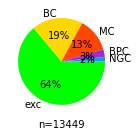

In [16]:
fig, ax = plt.subplots(figsize=(2, 2))
inh_ps = list(p_post_syn_type_given_pre.values())
ps = [1 - sum(inh_ps)] + inh_ps
ax.pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", counterclock=False)
ax.set_xlabel("n=" + str(n))
plt.show()

In [17]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_pie.png"))

In [18]:
# Possibly control for path distance in euclidean distance plot

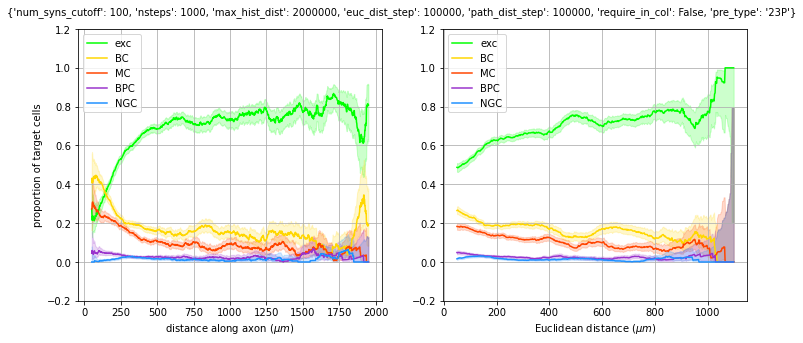

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for cell_type in cell_types:
    p = p_type_by_path_dists[cell_type].values
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    curr_n = path_dist_step * path_total_density.values * len(studied)
    # this standard error caclulation assumes each synapse is independently one type vs another, 
    # which is false because synapses form with the same cell many times
    lower, upper = get_error_bars(curr_n, p)
    axes[0].fill_between(path_bin_locs/1000, lower, upper, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
axes[0].set_ylim((-0.2, 1.2))
for cell_type in cell_types:
    p = p_type_by_euc_dists[cell_type].values
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    curr_n = euc_dist_step * euc_total_density.values * len(studied)
    lower, upper = get_error_bars(curr_n, p)
    axes[1].fill_between(euc_bin_locs/1000, lower, upper, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
axes[1].set_ylim((-0.2, 1.2))
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [24]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_p_type.png"))

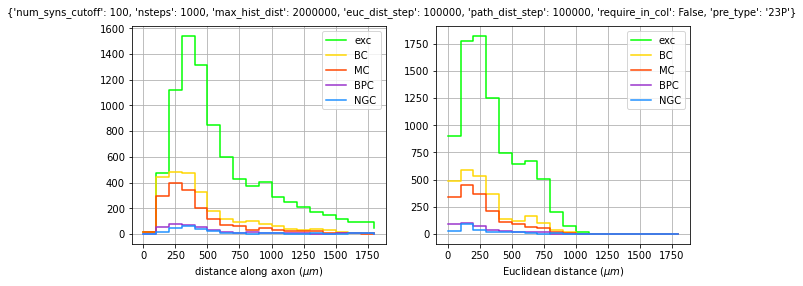

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [15]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_hists.png"))

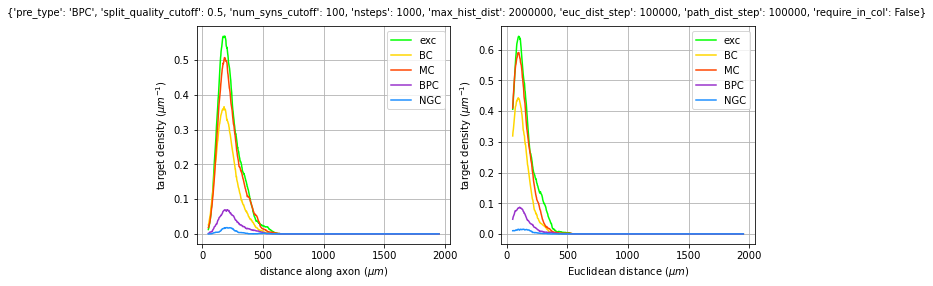

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [17]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_densities.png"))

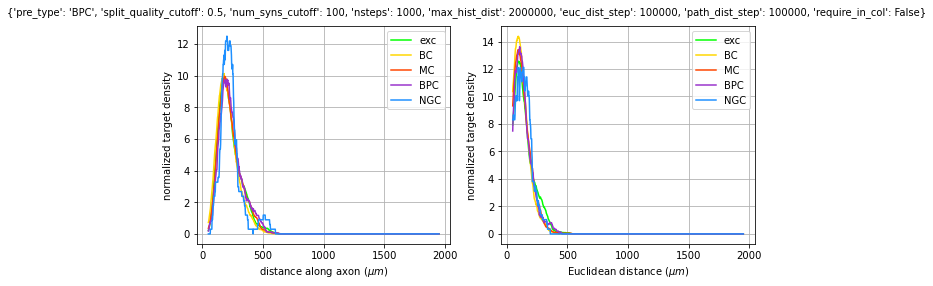

In [18]:
# normalized
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    d = path_densities[cell_type]
    d = d / np.mean(d)
    axes[0].plot(path_bin_locs/1000, d, color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("normalized target density")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    d = euc_densities[cell_type]
    d = d / np.mean(d)
    axes[1].plot(euc_bin_locs/1000, d, color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("normalized target density")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [19]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_normalized_densities.png"))

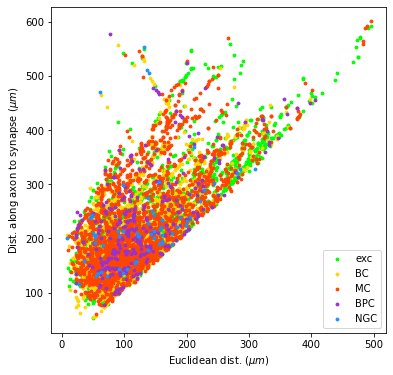

In [20]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [21]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_euc_v_path.png"))

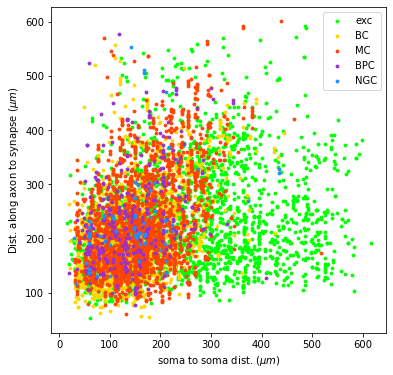

In [22]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [23]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_soma-soma_v_path.png"))

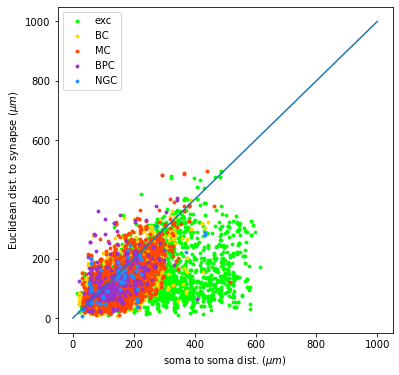

In [24]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
plt.plot([0, 1000], [0, 1000])
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [25]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_soma-soma_v_euc.png"))

# What layers are the post-synaptic cells in?

In [31]:
valid_ids = set(cells_by_root.index)  # TODO add a post_pt_nuc_id column

In [144]:
clean_output_df["n_syn"] = clean_output_df.groupby(["pre_pt_root_id", "post_pt_root_id"]).transform("count")["id"]

Text(0, 0.5, 'number of synapses')

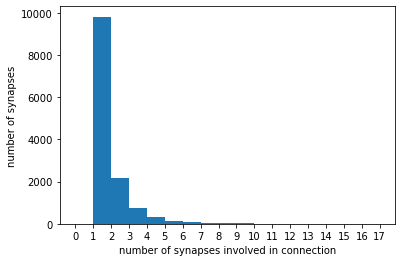

In [153]:
plt.hist(clean_output_df.n_syn, bins=range(max(clean_output_df.n_syn)))
plt.gca().set_xticks(range(max(clean_output_df.n_syn)))
plt.xlabel("number of synapses involved in connection")
plt.ylabel("number of synapses")

In [50]:
target_depths = []
target_n_syns = []
for i in range(len(clean_output_df)):
    ID = clean_output_df.post_pt_root_id.iloc[i]
    if ID in valid_ids:
        target_depths.append(cells_by_root.loc[ID].pt_position[1] * 4 / 1_000_000)
        target_n_syns.append(clean_output_df.n_syn.iloc[i])

In [52]:
target_n_syns = np.array(target_n_syns)

In [57]:
layer_borders = np.array([0.400516, 0.555516, 0.690516, 0.855516, 1.035516])  # 1 PCA mode

Text(0.5, 1.0, 'BPC-clean-subclass')

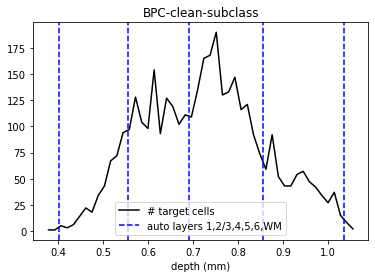

In [71]:
h, be = np.histogram(target_depths, bins=50, weights=1/target_n_syns)
bc = (be[1:] + be[:-1]) / 2
plt.plot(bc, h, color="k", label="# target cells")
plt.axvline(layer_borders[0], linestyle="--", color="blue", label="auto layers 1,2/3,4,5,6,WM")
for bound in layer_borders[1:]:
    plt.axvline(bound, linestyle="--", color="blue")
plt.legend()
plt.xlabel("depth (mm)")
plt.title(exp_name)

### Bipolar cells will almost never target cells shallower than 0.5 mm (ie, it only targets layers 3, 4, 5, 6)

# Find cells that have functional coregistration with the Baylor experiments.

In [134]:
baylor_cells = client.materialize.query_table("functional_coreg")

In [135]:
baylor_cells

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position
0,1,t,102531727972419182,864691136136642173,4,7,665,"[274864, 94064, 22046]"
1,2,t,94792540099826672,864691136208993724,4,7,740,"[218320, 104320, 19016]"
2,3,t,95846972288134035,864691135012527862,4,7,748,"[226336, 96064, 23453]"
3,4,t,93946810036875732,864691135683934135,4,7,782,"[212128, 94544, 23423]"
4,5,t,84730565597057981,864691135334528233,4,7,855,"[145158, 110036, 19355]"
...,...,...,...,...,...,...,...,...
9513,9604,t,81285383148906082,864691135699487010,9,4,7918,"[120302, 131320, 17704]"
9514,9605,t,93457321606855245,864691135888691081,9,4,7954,"[208494, 117448, 26619]"
9515,9606,t,93950383516629032,864691136237464380,9,4,8181,"[212192, 121488, 23821]"
9516,9607,t,106333769522794258,864691135715234074,9,4,8264,"[302317, 110006, 15316]"


In [136]:
baylor_root_ids = set(baylor_cells.pt_root_id.unique())
baylor_cells.index = baylor_cells.pt_root_id

In [137]:
clean_output_df["func_matched"] = [clean_output_df.post_pt_root_id.iloc[i] in baylor_root_ids for i in range(len(clean_output_df))]
clean_output_df["func_keys"] = [({col: baylor_cells.loc[clean_output_df.post_pt_root_id.iloc[i]][col] for col in ["session", "scan_idx", "unit_id"]} if clean_output_df.post_pt_root_id.iloc[i] in baylor_root_ids else np.nan) for i in range(len(clean_output_df))]

In [138]:
clean_output_df.query("func_matched").func_keys.values.tolist()

[{'session': 7, 'scan_idx': 4, 'unit_id': 4750},
 {'session': 9, 'scan_idx': 3, 'unit_id': 2570},
 {'session': 7, 'scan_idx': 4, 'unit_id': 2274},
 {'session': 9, 'scan_idx': 4, 'unit_id': 7655},
 {'session': 6, 'scan_idx': 6, 'unit_id': 4690},
 {'session': pt_root_id
  864691135467558284    4
  864691135467558284    8
  864691135467558284    8
  Name: session, dtype: int64,
  'scan_idx': pt_root_id
  864691135467558284    7
  864691135467558284    5
  864691135467558284    5
  Name: scan_idx, dtype: int64,
  'unit_id': pt_root_id
  864691135467558284    2626
  864691135467558284    2640
  864691135467558284    5463
  Name: unit_id, dtype: int64},
 {'session': 8, 'scan_idx': 5, 'unit_id': 2269},
 {'session': 4, 'scan_idx': 7, 'unit_id': 3210},
 {'session': 6, 'scan_idx': 4, 'unit_id': 4438},
 {'session': 6, 'scan_idx': 2, 'unit_id': 5320},
 {'session': 6, 'scan_idx': 6, 'unit_id': 7066},
 {'session': 8, 'scan_idx': 5, 'unit_id': 2307},
 {'session': 5, 'scan_idx': 3, 'unit_id': 2125},
 

In [17]:
# cells_by_root.loc[864691136370796936].cell_type

## Distribution and clustering of synapses in 3D space

In [18]:
from sklearn.cluster import DBSCAN

In [19]:
def vx_to_um(vx, res):
    return [res[i] * vx[i] / 1_000 for i in range(3)]

In [20]:
# I have to re-run this cleaning step because the root ids might have changed due to proofreading
roots_with_soma = set(cells_by_root.index)
include = np.array([root_id in roots_with_soma and type(cells_by_root.id.loc[root_id]) == np.int64 for root_id in clean_output_df.post_pt_root_id])
clean_output_df = clean_output_df[include].copy()

In [21]:
clean_output_df["syn_pos_um"] = clean_output_df.ctr_pt_position.apply(vx_to_um, args=[resolution])
clean_output_df["post_cell_type"] = [cells_by_root.loc[root].cell_type for root in clean_output_df.post_pt_root_id]

In [45]:
%matplotlib inline
plot = False
# {nuc_id: {cluster_id: {type: count within that cluster}, cumulative: {type: count within that cell}}}
n_type_in_distal_clusters = {nuc_id: dict() for nuc_id in studied}
for i in range(len(studied)):
    current_root = cells_by_nuc.loc[studied[i]].pt_root_id
    current_syns = clean_output_df.query(f"pre_pt_root_id == {current_root}")
    current_syn_locs = np.array(current_syns.syn_pos_um.values.tolist())
    current_soma_loc = np.array(vx_to_um(cells_by_nuc.loc[studied[i]].pt_position, res=resolution))
    current_syn_locs.shape, current_root
    
    n_type_in_distal_clusters[studied[i]]["cumulative"] = {t: 0 for t in cell_types + ["all"]}
    
    if plot:
        fig = plt.figure(dpi=130)
        ax = fig.add_subplot(projection='3d')

    clusterer = DBSCAN(eps=50, min_samples=10, metric="euclidean")
    labels = clusterer.fit_predict(current_syn_locs)
    ax.scatter(*current_soma_loc, s=100, c="k", label="soma loc")
    for lab in sorted(np.unique(labels)):
        pts = current_syn_locs[labels == lab]
        if len(pts) > 10 and lab != -1:  # must be a large cluster and not noise
            ctr_dist = np.sqrt(np.sum((pts.mean(axis=0) - current_soma_loc)**2))
            if ctr_dist > 400:
                these_syns = current_syns.iloc[labels == lab]
                n_type_in_distal_clusters[studied[i]][lab] = dict()
                sum_inh = 0
                for t in inh_cell_types:
                    t_count = len(these_syns.query(f"post_cell_type == '{t}'"))
                    sum_inh += t_count
                    n_type_in_distal_clusters[studied[i]]["cumulative"][t] += t_count
                    n_type_in_distal_clusters[studied[i]][lab][t] = t_count
                n_type_in_distal_clusters[studied[i]][lab]["exc"] = len(these_syns) - sum_inh
                n_type_in_distal_clusters[studied[i]][lab]["all"] = len(these_syns)
                n_type_in_distal_clusters[studied[i]]["cumulative"]["exc"] += len(these_syns) - sum_inh
                n_type_in_distal_clusters[studied[i]]["cumulative"]["all"] += len(these_syns)
                str_label = str(lab) + "--far"
            else:
                str_label = str(lab)
            if plot:
                ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], alpha=0.5, label=str_label)
        else:
            if plot:
                ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], alpha=0.3, color="gray", label="small")
    if plot:
        ax.legend(loc=[1,0])

C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  from ipykernel import kernelapp as app


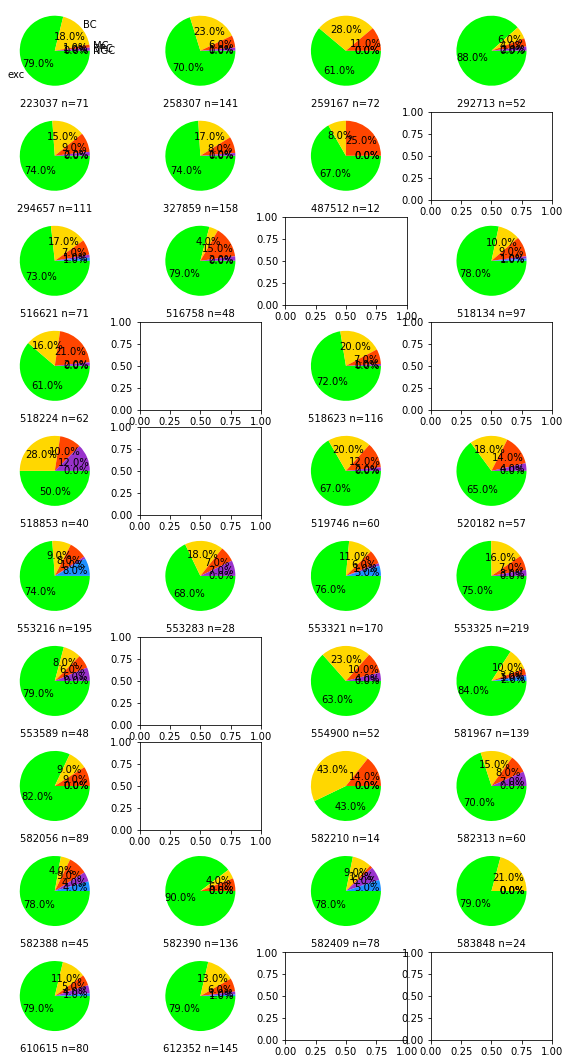

<Figure size 432x288 with 0 Axes>

In [46]:
fig, axs = plt.subplots((len(studied)  + 3) // 4, 4, figsize=(10, len(studied) / 2))
axes = axs.flatten()
ps = []
current_n = n_type_in_distal_clusters[studied[0]]["cumulative"]["all"]
for t in cell_types:
    ps.append(n_type_in_distal_clusters[studied[0]]["cumulative"][t] / current_n)
axes[0].pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(np.round(p)) + "%", counterclock=False)
axes[0].set_xlabel(str(studied[0]) + " n=" + str(current_n))
for i, cell_id in list(enumerate(studied))[1:]:
    ps = []
    current_n = n_type_in_distal_clusters[cell_id]["cumulative"]["all"]
    if current_n != 0:
        for t in cell_types:
            ps.append(n_type_in_distal_clusters[cell_id]["cumulative"][t] / current_n)
        axes[i].pie(ps, colors=plot_colors, autopct=lambda p: str(np.round(p)) + "%", pctdistance=0.6, counterclock=False)
        axes[i].set_xlabel(str(cell_id) + " n=" + str(current_n))
plt.show()
plt.tight_layout()

# visualizing soma-soma distance v synapse disance in neuroglancer
Also looking at the green outlier-ish points near the bottom

In [29]:
exc_idxs = list(range(len(syn_dfs["exc"])))
outlier_idxs = sorted(exc_idxs, key = lambda i: -syn_dfs["exc"].soma_to_soma_dist.iloc[i] + syn_dfs["exc"].euc_dist.iloc[i])[-50:]

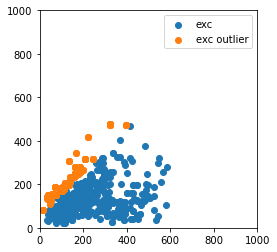

In [30]:
oidxs = np.random.choice(outlier_idxs, 200)
eidxs = np.random.choice(exc_idxs, 400)
plt.scatter(syn_dfs["exc"].soma_to_soma_dist.iloc[eidxs]/ 1000, syn_dfs["exc"].euc_dist.iloc[eidxs] / 1000, label="exc")
plt.scatter(syn_dfs["exc"].soma_to_soma_dist.iloc[oidxs]/ 1000, syn_dfs["exc"].euc_dist.iloc[oidxs] / 1000, label="exc outlier")
plt.xlim([0, 1000])
plt.ylim([0, 1000])
plt.gca().set_aspect(1)
plt.legend()

In [32]:
studied

[256426,
 258293,
 258362,
 258365,
 258379,
 260718,
 260724,
 262642,
 262692,
 262898,
 262909,
 262957,
 292675,
 292721,
 292831,
 292867,
 296527,
 298802,
 298829,
 298894,
 298961,
 301030,
 301200]

In [33]:
# This cell (864691136812081779) has more outlier synapses  (this might just be due to n)
o_syns = syn_dfs["exc"].iloc[outlier_idxs]
expected = []
observed = []
for nuc_id in studied:
    d = sum(o_syns.pre_pt_root_id == cells_by_nuc.pt_root_id.loc[nuc_id])
    print(nuc_id, cells_by_nuc.pt_root_id.loc[nuc_id], d, ns[nuc_id], 100 * d/ns[nuc_id])
    expected.append(ns[nuc_id] / n * 200)
    observed.append(d)

256426 864691135785592772 0 454 0.0
258293 864691136388862736 2 147 1.3605442176870748
258362 864691135382752730 2 271 0.7380073800738007
258365 864691135855791662 1 215 0.46511627906976744
258379 864691136065399960 5 856 0.5841121495327103
260718 864691136521811345 0 216 0.0
260724 864691136008709806 6 249 2.4096385542168677
262642 864691136008567724 4 153 2.6143790849673203
262692 864691136209200572 2 224 0.8928571428571429
262898 864691135491415647 0 128 0.0
262909 864691136090989748 2 295 0.6779661016949152
262957 864691135684173751 5 394 1.2690355329949239
292675 864691135994779306 0 147 0.0
292721 864691135367077881 4 737 0.5427408412483039
292831 864691135758647630 1 248 0.4032258064516129
292867 864691135012644086 1 298 0.33557046979865773
296527 864691136422909743 0 109 0.0
298802 864691135945746212 1 303 0.33003300330033003
298829 864691135348510679 0 139 0.0
298894 864691136903227570 2 347 0.5763688760806917
298961 864691135502071901 4 457 0.87527352297593
301030 86469113623

In [34]:
from scipy.stats import chisquare

In [35]:
list(zip(observed, map(lambda x: round(x), expected)))

[(0, 14),
 (2, 4),
 (2, 8),
 (1, 6),
 (5, 26),
 (0, 6),
 (6, 7),
 (4, 5),
 (2, 7),
 (0, 4),
 (2, 9),
 (5, 12),
 (0, 4),
 (4, 22),
 (1, 7),
 (1, 9),
 (0, 3),
 (1, 9),
 (0, 4),
 (2, 10),
 (4, 14),
 (3, 6),
 (5, 4)]

In [36]:
chisquare(observed, expected)

Power_divergenceResult(statistic=125.32220184548144, pvalue=1.8657669594960307e-16)

In [37]:
from nglui import statebuilder

image_path = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-em/aligned/v1'
segmentation_path = 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1'

img = statebuilder.ImageLayerConfig(image_path)
seg = statebuilder.SegmentationLayerConfig(segmentation_path)

In [38]:
points = statebuilder.PointMapper('ctr_pt_position', linked_segmentation_column='pre_pt_root_id')
anno_layer = statebuilder.AnnotationLayerConfig('o_syns', mapping_rules=points, linked_segmentation_layer=seg.name)

sb = statebuilder.StateBuilder([img, seg, anno_layer])

In [39]:
sb.render_state(o_syns, return_as='html')

The proximal-synapse excitatory target outliers seem to be short axons synapsing with the apical dendrites of deeper pyramids. https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://https://seungdata.princeton.edu/minnie65-phase3-em/aligned/v1%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22img%22%7D%2C%7B%22source%22:%22graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1%22%2C%22type%22:%22segmentation_with_graph%22%2C%22selectedAlpha%22:0.3%2C%22segments%22:%5B%2218446744073476563571%22%2C%22864691135780823632%22%2C%22864691136618404237%22%2C%22864691136812081779%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22graphOperationMarker%22:%5B%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%2C%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%5D%2C%22pathFinder%22:%7B%22color%22:%22#ffff00%22%2C%22pathObject%22:%7B%22annotationPath%22:%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%2C%22hasPath%22:false%7D%7D%2C%22name%22:%22seg%22%7D%2C%7B%22selectedAnnotation%22:%7B%22id%22:%2241999a3a80a51bc0d65c1e77fc70834026798cf1%22%7D%2C%22type%22:%22annotation%22%2C%22annotations%22:%5B%7B%22point%22:%5B273566%2C168136%2C15696%5D%2C%22type%22:%22point%22%2C%22id%22:%2211cdef0b1dd311600efe2fa49cb0b2a16d60b346%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B312334%2C161408%2C22784%5D%2C%22type%22:%22point%22%2C%22id%22:%22de4ac80bc160fd693f9ad50fd4d0fecd02ac04ed%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B350164%2C187298%2C22397%5D%2C%22type%22:%22point%22%2C%22id%22:%22a9ad70df1acf2ddd4177d0d56093450fb82f592e%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B278182%2C167718%2C16031%5D%2C%22type%22:%22point%22%2C%22id%22:%2241999a3a80a51bc0d65c1e77fc70834026798cf1%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B318586%2C176224%2C15403%5D%2C%22type%22:%22point%22%2C%22id%22:%22d54c10469fb2bb04c5cc3e1db914f5eb4c71a7b7%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B305388%2C160128%2C23639%5D%2C%22type%22:%22point%22%2C%22id%22:%22ab4fc52aaff472f03d7e0cf1880192ade4498f75%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B311801%2C164358%2C17864%5D%2C%22type%22:%22point%22%2C%22id%22:%22056b207c3b7bd19a3a4f18c060f3bdbf4f4fbc10%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B334184%2C167722%2C17344%5D%2C%22type%22:%22point%22%2C%22id%22:%220499f8e6ea3aa46492d554efaa593ec9aee620c5%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B314678%2C169198%2C21423%5D%2C%22type%22:%22point%22%2C%22id%22:%226bf435d3628d7c3d37b155f0643ec267ab7d33b3%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B335846%2C137334%2C15426%5D%2C%22type%22:%22point%22%2C%22id%22:%2205f6af515163ab52b4e29be7d9647504c543b8c5%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B329234%2C100466%2C18502%5D%2C%22type%22:%22point%22%2C%22id%22:%22c929730cdfba278a0632cf6c883c6606560284f9%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%5D%2C%22annotationTags%22:%5B%5D%2C%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22linkedSegmentationLayer%22:%22seg%22%2C%22bracketShortcutsShowSegmentation%22:true%2C%22annotationSelectionShowsSegmentation%22:true%2C%22name%22:%22o_syns%22%7D%5D%2C%22navigation%22:%7B%22pose%22:%7B%22position%22:%7B%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22voxelCoordinates%22:%5B278182.40625%2C167718.359375%2C16031.849609375%5D%7D%7D%2C%22zoomFactor%22:18.975471672717056%7D%2C%22perspectiveOrientation%22:%5B-0.048757269978523254%2C0.17419981956481934%2C0.06561703234910965%2C0.9813111424446106%5D%2C%22perspectiveZoom%22:7380.246935540536%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22layer%22:%22o_syns%22%2C%22visible%22:true%7D%2C%22layout%22:%22xy-3d%22%7D

In [40]:
points = statebuilder.PointMapper('ctr_pt_position', linked_segmentation_column='pre_pt_root_id')
anno_layer = statebuilder.AnnotationLayerConfig('e_syns', mapping_rules=points, linked_segmentation_layer=seg.name)

sb = statebuilder.StateBuilder([img, seg, anno_layer])

In [41]:
e_syns = syn_dfs["exc"].iloc[eidxs].query("pre_pt_root_id == 864691135937286404")
sb.render_state(e_syns, return_as='html')

In [42]:
e_syns.query("post_pt_root_id == 864691136618413965")

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,pre_pt_level2_id,pre_pt_mesh_ind,skel_idx,soma_to_soma_dist,euc_dist,path_dist


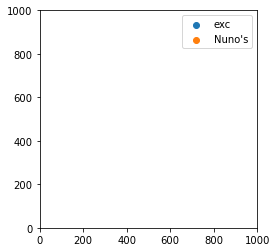

In [43]:
plt.scatter(e_syns.soma_to_soma_dist / 1000, e_syns.euc_dist / 1000, label="exc")
nunos = e_syns.query("post_pt_root_id == 864691136618413965")
plt.scatter(nunos.soma_to_soma_dist / 1000, nunos.euc_dist / 1000, label="Nuno's")
plt.xlim([0, 1000])
plt.ylim([0, 1000])
plt.gca().set_aspect(1)
plt.legend()

soma-to-soma distance $\approx$ euclidean distance to synapse: https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://https://seungdata.princeton.edu/minnie65-phase3-em/aligned/v1%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22img%22%7D%2C%7B%22source%22:%22graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1%22%2C%22type%22:%22segmentation_with_graph%22%2C%22selectedAlpha%22:0.3%2C%22segmentColors%22:%7B%22864691135278221217%22:%22#4dfffc%22%7D%2C%22segments%22:%5B%22864691135278221217%22%2C%22864691135937286404%22%2C%22864691135975465539%22%2C%22864691136618413965%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22graphOperationMarker%22:%5B%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%2C%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%5D%2C%22pathFinder%22:%7B%22color%22:%22#ffff00%22%2C%22pathObject%22:%7B%22annotationPath%22:%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%2C%22hasPath%22:false%7D%7D%2C%22name%22:%22seg%22%7D%2C%7B%22selectedAnnotation%22:%7B%22id%22:%22a66ac612711e3b885dac1cb21929c4cb0416f83f%22%7D%2C%22type%22:%22annotation%22%2C%22annotations%22:%5B%7B%22point%22:%5B338318%2C140850%2C26010%5D%2C%22type%22:%22point%22%2C%22id%22:%22a66ac612711e3b885dac1cb21929c4cb0416f83f%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B302254%2C150722%2C24404%5D%2C%22type%22:%22point%22%2C%22id%22:%22508816560474897916719a981e5dd2a8b76c0650%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B297152%2C115608%2C24116%5D%2C%22type%22:%22point%22%2C%22id%22:%22642a1c2b4840e6bfa5cbce6eadbaa9dce510a267%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B358688%2C141270%2C23544%5D%2C%22type%22:%22point%22%2C%22id%22:%22684e1af6f3055fee5df1bfa299408448c418f149%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B310494%2C106348%2C22200%5D%2C%22type%22:%22point%22%2C%22id%22:%22e8e7079b456869c55b811021e8ce11bbec9ceb9d%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B313068%2C132112%2C23078%5D%2C%22type%22:%22point%22%2C%22id%22:%22dff5b7b83e726420b2fd1bcdcca119f0b2011e14%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%5D%2C%22annotationTags%22:%5B%5D%2C%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22linkedSegmentationLayer%22:%22seg%22%2C%22bracketShortcutsShowSegmentation%22:true%2C%22annotationSelectionShowsSegmentation%22:true%2C%22name%22:%22e_syns%22%7D%5D%2C%22navigation%22:%7B%22pose%22:%7B%22position%22:%7B%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22voxelCoordinates%22:%5B310492.6875%2C106347.59375%2C22196.900390625%5D%7D%7D%2C%22zoomFactor%22:2%7D%2C%22perspectiveOrientation%22:%5B-0.031439196318387985%2C-0.3732105493545532%2C-0.16680458188056946%2C0.9120864272117615%5D%2C%22perspectiveZoom%22:7279.7438133281685%2C%22selectedLayer%22:%7B%22layer%22:%22seg%22%2C%22visible%22:true%7D%2C%22layout%22:%223d%22%7D

## Look for the bbox of a new column to study that hasn't been proofread

In [44]:
# use this cell if you want to go through the cells one at a time
# gather a list of thoroughly proofread layer 2/3 pyramidal cells
allow_clean = True
proofreading_status = client.materialize.query_table('proofreading_status_public_release')
pre_proofread_cells = proofreading_status.query(f"(status_axon == 'extended' or (status_axon == 'clean' and {allow_clean})) and valid_id == pt_root_id")
post_proofread_cells = proofreading_status.query(f"(status_axon == 'extended' or status_axon == 'clean') and valid_id == pt_root_id")
# proofread_cells = set.union(col_prf_root_ids, post_proofread_cells.pt_root_id.unique())  # cells that are clean according to either proofreading_status_public_release or allen_v1_column_pyc_proof 
# proofread_cells = proofreading_status.query("status_axon == 'extended' and valid_id == pt_root_id")
pre_type_cells = all_cells.query(f"cell_type == '{pre_type}'")
root_ids_to_study = list(set.intersection(set(pre_type_cells.pt_root_id.unique()), set(pre_proofread_cells.valid_id.unique())))
# if require_in_col:
#     root_ids_to_study = list(set.intersection(set(root_ids_to_study), col_cells.pt_root_id.unique()))
nucs_to_study = list(cells_by_root.id.loc[root_ids_to_study].values)  # permanent nucleus id of cell
print(len(root_ids_to_study), len(nucs_to_study))
if len(root_ids_to_study) != len(nucs_to_study):
    raise ValueError("Some cells were not proofread properly")

27 27


In [45]:
cells = cells_by_nuc.loc[nucs_to_study]

In [46]:
points = statebuilder.PointMapper('pt_position', linked_segmentation_column='id')
anno_layer = statebuilder.AnnotationLayerConfig('proofread_cells', mapping_rules=points, linked_segmentation_layer=seg.name)

sb = statebuilder.StateBuilder([img, seg, anno_layer])
sb.render_state(post_proofread_cells, return_as='html')

In [47]:
# (convert nuc id to root id)
nuc = 267006
nuc, cells_by_nuc.loc[nuc].pt_root_id

(267006, 864691136194453992)

## Individual figures together

C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  # Remove the CWD from sys.path while we load stuff.


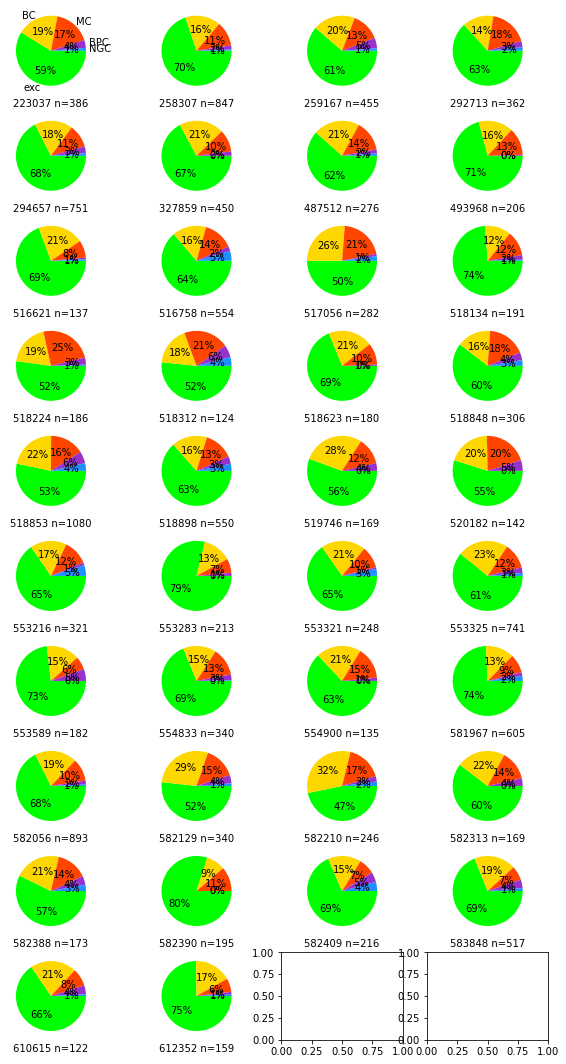

<Figure size 432x288 with 0 Axes>

In [31]:
fig, axs = plt.subplots((len(studied)  + 3) // 4, 4, figsize=(10, len(studied) / 2))
axes = axs.flatten()
inh_ps = list(p_post_syn_type_given_pres[studied[0]].values())
ps = [1 - sum(inh_ps)] + inh_ps
axes[0].pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", counterclock=False)
axes[0].set_xlabel(str(studied[0]) + " n=" + str(ns[studied[0]]))
for i, cell_id in list(enumerate(studied))[1:]:
    inh_ps = list(p_post_syn_type_given_pres[cell_id].values())
    ps = [1 - sum(inh_ps)] + inh_ps
    axes[i].pie(ps, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", pctdistance=0.6, counterclock=False)
    axes[i].set_xlabel(str(cell_id) + " n=" + str(ns[cell_id]))
plt.show()
plt.tight_layout()

In [49]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_pies.png"))

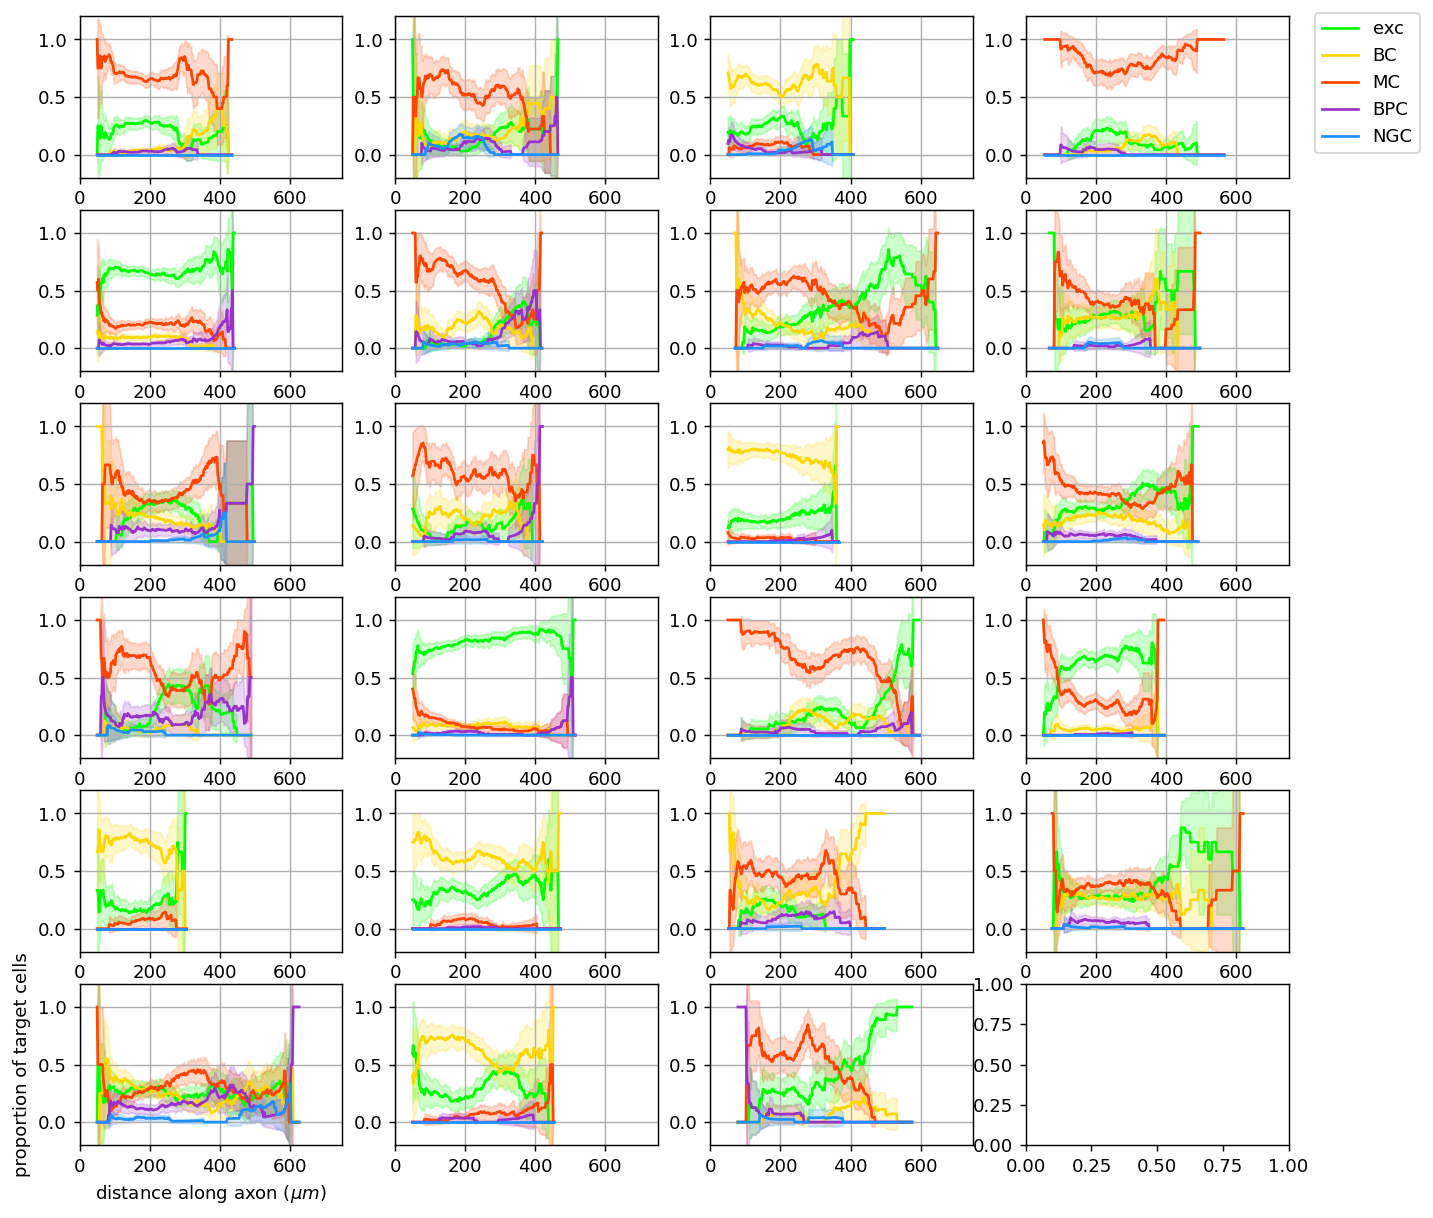

<Figure size 432x288 with 0 Axes>

In [50]:
fig, axs = plt.subplots((len(studied) + 3) // 4, 4, figsize=(12, len(studied) / 2), dpi=130)
axes = axs.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        p = all_p_type_by_path_dists[cell_id][cell_type]
        axes[i].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
        std_hat = np.sqrt(p * (1 - p) / (path_dist_step * all_path_total_density[cell_id]))
        axes[i].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
#     axes[i].set_title("cell=" + str(cell_id))
    axes[i].grid()
    axes[i].set_ylim((-0.2, 1.2))
    axes[i].set_xlim((0, max_hist_dist/1000))
#     axes[i].set_xticklabels([''] * 4)
# axes[16].set_xticklabels([0, 500, 1000, 1500, 2000])
axes[3].legend(loc=(1.1, 0.15))
axs[-1, 0].set_xlabel("distance along axon ($\mu m$)")
axs[-1, 0].set_ylabel("proportion of target cells")
plt.show()
plt.tight_layout()

In [51]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_p_types_path.png"))

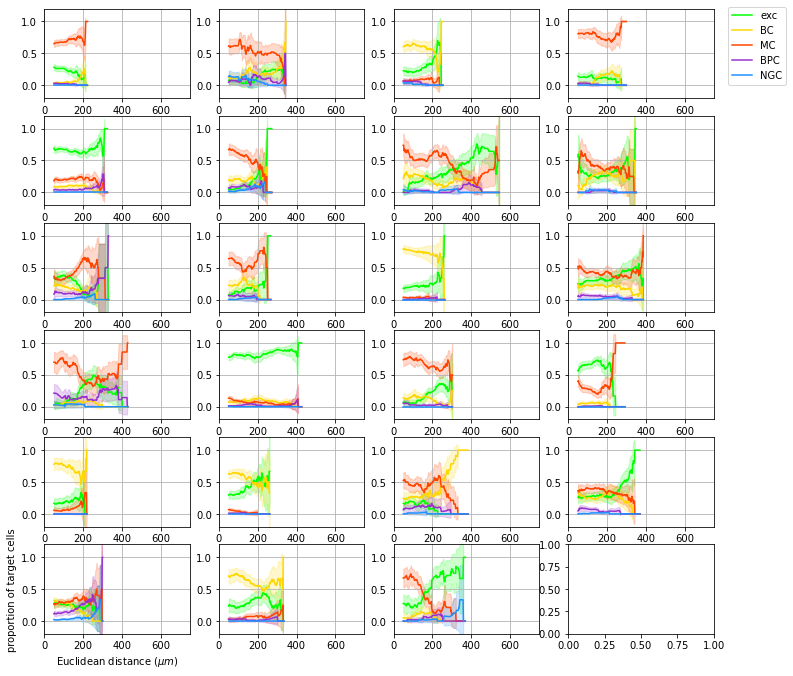

<Figure size 432x288 with 0 Axes>

In [58]:
fig, axs = plt.subplots((len(studied) + 3) // 4, 4, figsize=(12, len(studied) / 2))
axes = axs.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        p = all_p_type_by_euc_dists[cell_id][cell_type]
        axes[i].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
        std_hat = np.sqrt(p * (1 - p) / (euc_dist_step * all_euc_total_density[cell_id]))
        axes[i].fill_between(euc_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
    axes[i].grid()
    axes[i].set_ylim((-0.2, 1.2))
    axes[i].set_xlim((0, max_hist_dist/2000))
axes[3].legend(loc=(1.1, 0.15))
axs[-1, 0].set_xlabel("Euclidean distance ($\mu m$)")
axs[-1, 0].set_ylabel("proportion of target cells")
plt.show()
plt.tight_layout()

In [59]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_p_types_euc.png"))

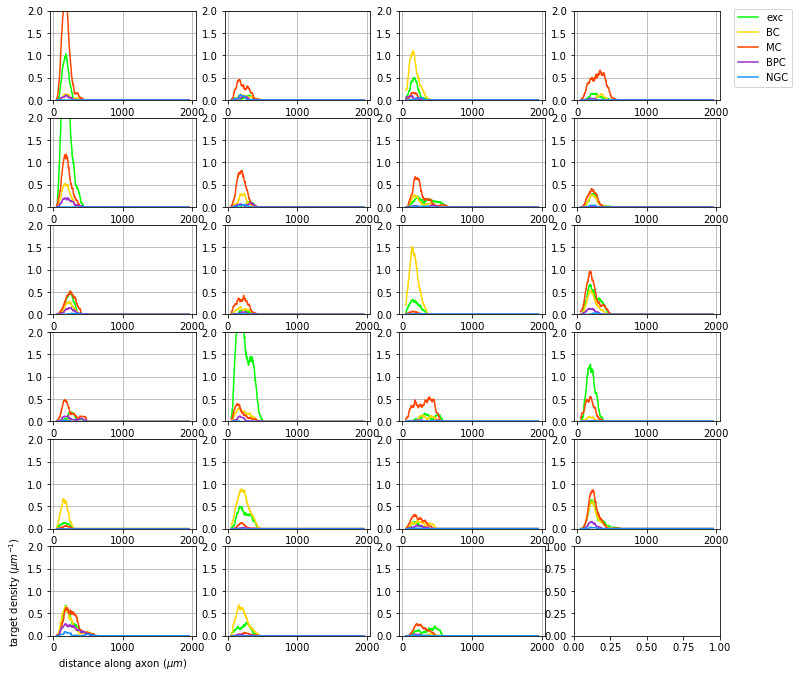

<Figure size 432x288 with 0 Axes>

In [54]:
fig, axs = plt.subplots((len(studied) + 3) // 4, 4, figsize=(12, len(studied) / 2))
axes = axs.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        axes[i].plot(path_bin_locs/1000, 1000*all_path_densities[cell_id][cell_type], color=type_colors[cell_type], label=cell_type)
    axes[i].grid()
    axes[i].set_ylim((0, 2))
axes[3].legend(loc=(1.1, 0.15))
axs[-1, 0].set_xlabel("distance along axon ($\mu m$)")
axs[-1, 0].set_ylabel("target density ($\mu m^{-1}$)")
plt.show()
plt.tight_layout()

In [55]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_densities_path.png"))

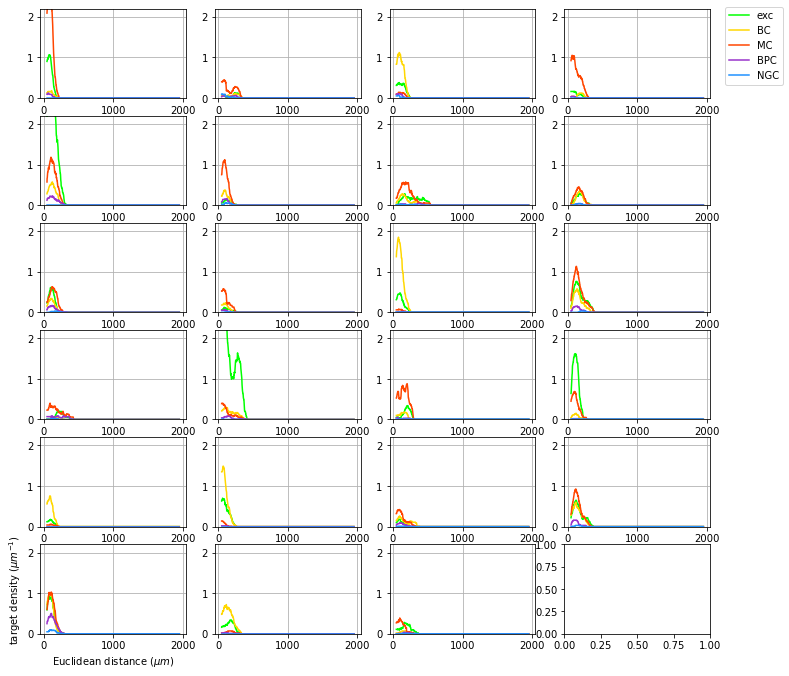

<Figure size 432x288 with 0 Axes>

In [56]:
fig, axs = plt.subplots((len(studied) + 3) // 4, 4, figsize=(12, len(studied) / 2))
axes = axs.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        axes[i].plot(euc_bin_locs/1000, 1000*all_euc_densities[cell_id][cell_type], color=type_colors[cell_type], label=cell_type)
    axes[i].grid()
    axes[i].set_ylim((0, 2.2))
axes[3].legend(loc=(1.1, 0.15))
axs[-1, 0].set_xlabel("Euclidean distance ($\mu m$)")
axs[-1, 0].set_ylabel("target density ($\mu m^{-1}$)")
plt.show()
plt.tight_layout()

In [57]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_densities_euc.png"))

# Miscellaneous

## See if there's anything interesting going on with number of synapses formed between pairs of cells
Correlation between number of synapses between two cells and the soma-soma distance, average path distance, or average euclidean distance to the synapse

In [151]:
clean_output_df["num_syns"] = clean_output_df.groupby(["pre_pt_root_id", "post_pt_root_id"]).transform("count")["id"]

In [152]:
clean_output_df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,post_pt_level2_id,post_pt_mesh_ind,soma_to_soma_dist,euc_dist,path_dist,num_syns
1,"[293522, 147748, 26411]",349904061,"[293492, 147798, 26409]",864691135570739693,105142587589245793,1.772002e+17,349.0,"[293550, 147722, 26415]",864691135937286404,105142587589248845,4984,t,249,NaN,NaN,302631.491607,288515.885178,406258.002281,1
3,"[324832, 176170, 24522]",404991590,"[324822, 176244, 24527]",864691136536079010,109438860287021951,1.814965e+17,7470.0,"[324870, 176182, 24517]",864691135937286404,109438860287009992,9164,t,3283,NaN,NaN,469767.037549,226724.808135,346531.519348,1
4,"[339498, 136072, 26228]",432641298,"[339466, 136144, 26225]",864691135695952538,111403825272881331,1.835318e+17,10687.0,"[339568, 136096, 26223]",864691135937286404,111474194017051993,12812,t,4724,NaN,NaN,243127.039582,260071.288442,454764.199829,3
5,"[258344, 201644, 22693]",296557493,"[258322, 201634, 22693]",864691136617334747,100294359316104108,1.723520e+17,25.0,"[258352, 201712, 22694]",864691135937286404,100294359316104182,3472,t,19,NaN,NaN,277477.673221,371614.578831,475777.330688,2
8,"[350752, 147382, 26083]",445215606,"[350800, 147384, 26087]",864691136945679327,113023818150753858,1.850110e+17,11523.0,"[350702, 147422, 26076]",864691135937286404,112953449406561883,20012,t,5119,NaN,NaN,306046.482639,267623.464323,454145.014893,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,"[215806, 133710, 22806]",224081694,"[215852, 133762, 22802]",864691136174962694,94444613859091446,1.665022e+17,11602.0,"[215790, 133788, 22812]",864691136039640318,94444613859106854,18776,t,5422,NaN,NaN,144898.155682,146085.651150,445531.878387,1
575,"[174687, 194933, 19142]",151701776,"[174680, 194938, 19139]",864691136105687001,88823360192231781,1.608106e+17,3346.0,"[174554, 194894, 19141]",864691136039640318,88752991448053427,15044,t,1617,NaN,NaN,320058.067631,309339.117630,386785.083679,2
576,"[211884, 134238, 21720]",214443585,"[211810, 134314, 21726]",864691135415817402,93881732490872271,1.659393e+17,11453.0,"[211958, 134306, 21721]",864691136039640318,93881732490879580,13928,t,5325,NaN,NaN,306614.282564,126056.283302,267744.717010,1
583,"[183708, 130512, 21873]",174328728,"[183652, 130528, 21868]",864691135474752320,90010970524959605,NaN,NaN,"[183650, 130546, 21880]",864691136039640318,90010970524974714,860,t,3038,1.620686e+17,6966.0,214231.016989,32141.810777,32850.378876,1


In [174]:
from scipy.stats import pearsonr, gamma

In [156]:
r, p = pearsonr(clean_output_df.soma_to_soma_dist, clean_output_df.num_syns)
r, p, r**2  # this result might be obvious just due to the fact that more synapses form proximally

(-0.146304470409582, 2.252372164481527e-50, 0.021404998061828256)

In [197]:
# now try again with only one data point per pre-post-pair, rather than per synapse
soma_dists = []
num_syns = []
path_dists = []
euc_dists = []
pre_post_pairs = np.unique(list(zip(clean_output_df.pre_pt_root_id, clean_output_df.post_pt_root_id)), axis=0)
for pre_id, post_id in pre_post_pairs:
    conn = clean_output_df.query(f"pre_pt_root_id == {pre_id} and post_pt_root_id == {post_id}")
    soma_dists.append(conn.soma_to_soma_dist.iloc[0])
    num_syns.append(conn.num_syns.iloc[0])
    path_dists.append(conn.path_dist.values)
    euc_dists.append(conn.euc_dist.values)
    

In [172]:
r, p = pearsonr(soma_dists, num_syns)
r, p, r**2  # this result might be obvious just due to the fact that more synapses form proximally

(-0.09976132298408119, 3.039245548090911e-20, 0.009952321563534166)

In [200]:
r, p = pearsonr(list(map(np.mean, path_dists)), num_syns)
r, p, r**2  # this result might be obvious just due to the fact that more synapses form proximally

(-0.10720849999823454, 3.7850749890473145e-23, 0.011493662471871455)

In [201]:
r, p = pearsonr(list(map(np.mean, euc_dists)), num_syns)
r, p, r**2  # this result might be obvious just due to the fact that more synapses form proximally

(-0.09365095066707803, 5.131328784521374e-18, 0.008770500560847482)

### Make a fake population of cells with a gamma distribution of soma-soma distances and see if the same correlation exists
I could alternatively not do any simulation. Rather, look at the probability of cell A forming another synapse with cell B given one already exists at distance d.

In [312]:
nfake = 400
npre = 50  # pre is a subset of fake--the closest ones to the center
scale = 12
fake_cell_locs = (np.random.random((nfake, 3)) - 0.5) * scale
fake_pre_locs = fake_cell_locs[np.argsort(np.sum(fake_cell_locs ** 2, axis=1))[:npre]]

In [331]:
fake_synapses = np.zeros((npre, nfake))
fake_soma_dists = np.zeros((npre, nfake))
ds = []
ntries = 50
likelihood = 1
a = 1.01
for pre in range(npre):
    print(pre)
    for post in range(nfake):
        pre_loc = fake_pre_locs[pre]
        d = np.sqrt(np.sum((pre_loc - fake_cell_locs[post])**2))
        fake_soma_dists[pre, post] = d
        l = gamma.pdf(d, a) * likelihood
        num_syns = sum(np.random.random(size=ntries) < l)
        fake_synapses[pre, post] += num_syns
        ds.extend([d] * num_syns)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


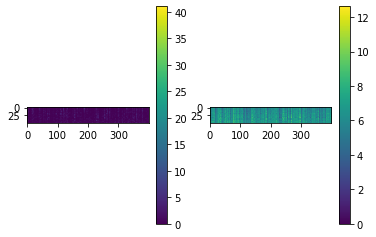

In [332]:
# fig, axes = plt.subplots(1, 2)
plt.subplot(121)
plt.imshow(fake_synapses)
plt.colorbar()
plt.subplot(122)
plt.imshow(fake_soma_dists)
plt.colorbar()

In [333]:
r, p = pearsonr(fake_soma_dists.flatten()[syn_idxs], fake_synapses.flatten()[syn_idxs])
r, p, r**2  # this suggests that in real data, farther away cells "actively" form multiple synapses when connecting with
# farther cells, although this simulation is not conculsive

(-0.6412782571885243, 0.0, 0.4112378031427511)

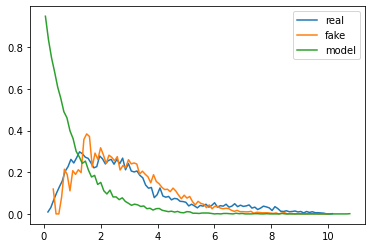

In [334]:
# the shapes don't match because there are more cells far away than close by
soma_dists_model = gamma.rvs(a=a, size=len(soma_dists))

soma_hist, edge = np.histogram(np.array(soma_dists) / 100000, bins=100, density=True)
model_hist, edge_model = np.histogram(soma_dists_model, bins=100, density=True)
fake_soma_hist, edge_fake = np.histogram(ds, bins=100, density=True)

bin_centers = (edge[1:] + edge[:-1]) / 2
bin_centers_model = (edge_model[1:] + edge_model[:-1]) / 2
bin_centers_fake = (edge_fake[1:] + edge_fake[:-1]) / 2
plt.plot(bin_centers, soma_hist, label="real")
plt.plot(bin_centers_fake, fake_soma_hist, label="fake")
plt.plot(bin_centers_model, model_hist, label="model")
plt.legend()

In [53]:
prf = client.materialize.query_table("allen_v1_column_pyc_proof")

In [57]:
864691135293126156 in prf.pt_root_id

False

In [56]:
prf

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,1,t,dendrites_clean,clean,90505063495624451,864691135478396358,"[186944, 141984, 21399]"
1,2,t,dendrites_clean,clean,90501971186083575,864691136266561524,"[187280, 118848, 21755]"
2,3,t,dendrites_clean,clean,88253401120843383,864691135560494305,"[170928, 142608, 21356]"
3,4,t,dendrites_clean,clean,88179046781337396,864691134917454858,"[170208, 113008, 22507]"
4,5,t,dendrites_clean,clean,89376827126485917,864691135367211513,"[178976, 124432, 21326]"
...,...,...,...,...,...,...,...
225,226,t,dendrites_clean,clean,88199318758477422,864691135367232505,"[170144, 264128, 20473]"
226,227,t,dendrites_clean,clean,88058856282265578,864691135367231993,"[169264, 265936, 21424]"
227,228,t,dendrites_clean,clean,88551093826796513,864691135394159093,"[173088, 263776, 20722]"
228,229,t,dendrites_clean,clean,91219952212160819,864691135753905357,"[192240, 224992, 21472]"


# Interesting findings

BC 305046 forms 27 synapses with a cell that's remarkably far away. This cell is labelled BC, but it's actually P (so this is actually nothing special). https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/6089733872549888. 

Many bipolar cells preferentially target Martinotti cells as was found (physiologically - using pvalb, sst, and vip) in inhibitionOfInhibition2013.

pre-BPCs are all correct
pre-BCs are all correct

pre-5P_IT are all correct except (269251, 864691135293200652) and (264848, 864691135501945437)
pre-5P_IT are all correct except (267006, 864691136194453992) and (275879, 864691136922965732)

pre-5P_PT (267006 864691136194453992) is not correct (I think Martinnoti?)

In [156]:
cells_by_nuc.loc[[258379, 292721, 260718, 292831]].pt_root_id.values

array([864691136065399960, 864691135367077881, 864691136521811345,
       864691135758647630], dtype=int64)

the above 4 BP cells: https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/6053115103019008. The first two are martinotti targeting and the second two are pyramid targeting

In [222]:
import time
time.time()

1626567380.8264415

In [228]:
root_ids = []
for nuc_id in studied:
    root_ids.append(cells_by_nuc.pt_root_id.loc[nuc_id])
start = time.time()
res = client.materialize.query_table("synapses_pni_2", filter_in_dict={"pre_pt_root_id": root_ids})
print(time.time() - start)

5.138987302780151


In [227]:
len(studied)

11

In [229]:
len(res)

9387

In [4]:
baskets = all_cell_types.query("cell_type == 'BC' and num_soma == 1").pt_root_id.values

In [5]:
special_cells = []

In [7]:
valid_ids = set(all_cell_types.query("num_soma == 1").pt_root_id)
for i in range(5, len(baskets) // 100 + 1):
    current_baskets = baskets[100*i:100*(i + 1)]
    synapses = client.materialize.synapse_query(pre_ids=current_baskets)  # select_columns=["pre_pt_root_id", "post_pt_root_id"]
    synapses.index = synapses.pre_pt_root_id
    current_baskets = baskets[100*i:100*(i + 1)]
    for root in current_baskets:
        post_roots = [p for p in synapses.query(f"pre_pt_root_id == {root}").post_pt_root_id.values if p in valid_ids]
        ctypes = cells_by_root.loc[post_roots].cell_type
        p_mc = sum(ctypes == "MC") / len(ctypes) if len(ctypes) > 0 else np.nan
        if p_mc > 0.16 and len(ctypes) > 200:
            print(i, root, len(ctypes), p_mc)
            special_cells.append(root)
    print(i * 100)


500


600
7 864691136134661771 783 0.17113665389527458
700
800
900
1000
1100
1200
1300
14 864691135366952185 639 0.20187793427230047
1400
1500
16 864691136116144548 792 0.17045454545454544
1600
1700
18 864691135590002187 1335 0.2202247191011236
1800
1900


2000


2100
2200


2300
2400
25 864691135807462941 1133 0.22594880847308033
25 864691136451107583 395 0.16455696202531644
2500
2600
2700


In [14]:
special_cells

[864691136965844430,
 864691135495010500,
 864691136134661771,
 864691135366952185,
 864691136116144548,
 864691135590002187,
 864691135807462941,
 864691136451107583]

# What percent of all synapses are onto each cell type?
## proofread pre

In [106]:
types = all_cells.cell_type.unique()
overall_props = dict()
for t in types:
    prop = sum(all_cells.cell_type == t) / len(all_cells)
    overall_props[t] = prop
    print(t + "\t" + str(prop))

23P	0.2572151464471032
4P	0.22731106250982747
5P_IT	0.1104964478179453
6CT	0.1412153179810455
5P_PT	0.02564432437068485
6IT	0.10610803779464528
5P_NP	0.018125419900796202
BPC	0.022728247351944765
NGC	0.011306945695212773
BC	0.04301213602641623
MC	0.03683691410437841


In [111]:
proofreading_status = client.materialize.query_table("proofreading_status_public_release")
proofreading_status = proofreading_status.query("valid_id == pt_root_id and (status_axon == 'clean' or status_axon == 'extended')")

In [117]:
valid_ids = set.intersection(set(proofreading_status.pt_root_id), all_cells.pt_root_id)
proofreading_status = proofreading_status[[root in valid_ids for root in proofreading_status.pt_root_id]]
len(proofreading_status)

234

In [118]:
proofreading_status["cell_type"] = [cells_by_root.loc[root_id].cell_type for root_id in proofreading_status.pt_root_id]

In [124]:
proofread_props = dict()
for t in types:
    ni = sum(proofreading_status.cell_type == t)
    prop = ni / len(proofreading_status)
    proofread_props[t] = prop
    print(t + "\t" + str(ni) + "\t" + str(prop))

23P	78	0.3333333333333333
4P	28	0.11965811965811966
5P_IT	19	0.0811965811965812
6CT	1	0.004273504273504274
5P_PT	11	0.04700854700854701
6IT	1	0.004273504273504274
5P_NP	5	0.021367521367521368
BPC	27	0.11538461538461539
NGC	6	0.02564102564102564
BC	41	0.1752136752136752
MC	17	0.07264957264957266


In [125]:
syns = pd.DataFrame()
for t in types:
    print(t)
    pre = proofreading_status.query(f"cell_type == '{t}'").pt_root_id.values
    these_syns = client.materialize.synapse_query(pre_ids=pre)
    these_syns["weight"] = overall_props[t] / proofread_props[t]  # weight by how over/under represented each type is
    syns = pd.concat([syns, these_syns])
syns

23P
4P
5P_IT
6CT
5P_PT
6IT
5P_NP
BPC
NGC
BC
MC


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,weight
0,254187323,t,96908687934996856,864691136237620540,96908687935003660,864691135207715961,1536,"[233830, 142382, 21172]","[233928, 142484, 21176]","[233852, 142358, 21170]",0.771645
1,367491011,t,105919942108940243,864691134884807418,105919942108953181,864691136902999474,204,"[299484, 172656, 25069]","[299510, 172600, 25076]","[299538, 172674, 25072]",0.771645
2,402091147,t,109018021808508698,864691136309871706,109018021808492130,864691136003665354,3540,"[321836, 186342, 21141]","[321794, 186330, 21135]","[321778, 186336, 21135]",0.771645
3,192640640,t,91835129034625139,864691136237620540,91905429059313042,864691135359152984,1292,"[197130, 89866, 21660]","[197214, 89770, 21649]","[197146, 89814, 21658]",0.771645
4,258423467,t,96767057093671773,864691136237620540,96766988374176234,864691135968881253,980,"[232990, 135414, 21380]","[232952, 135296, 21376]","[232968, 135342, 21377]",0.771645
...,...,...,...,...,...,...,...,...,...,...,...
56865,179367363,t,90569934681708508,864691135754910674,90570003401175978,864691135360168007,872,"[187904, 101022, 21487]","[187912, 101124, 21487]","[187914, 101092, 21490]",0.507049
56866,167986949,t,89593637209958531,864691135754758610,89593637209955358,864691135355030223,1896,"[180592, 166908, 22494]","[180586, 166864, 22490]","[180514, 166902, 22494]",0.507049
56867,147176331,t,87901488881676913,864691135697462549,87831120137538364,864691136056317400,1548,"[167992, 142484, 22804]","[167962, 142460, 22812]","[167991, 142501, 22806]",0.507049
56868,151524403,t,88531371336813180,864691135884128368,88531371336818225,864691136309819994,4328,"[172814, 116770, 20570]","[172830, 116636, 20578]","[172866, 116698, 20574]",0.507049


In [127]:
syns["num_synapses"] = syns.groupby("pre_pt_root_id").transform("count")["id"]

In [149]:
valid_ids = set(all_cells_by_root.index)
inh_cell_types = ['BC', 'MC', 'BPC', 'NGC']  # Basket Cell, Martinotti Cell, Bipolar Cell, Nuerogliaform Cells
cell_types = ['exc'] + inh_cell_types
plot_colors = ["lime", "gold", "orangered", "darkorchid", "dodgerblue"]
type_colors = dict(zip(cell_types, plot_colors))
p_types = dict((t, 0) for t in cell_types)
total_n = 0
for i in range(len(syns)):
    target_id = syns.post_pt_root_id.iloc[i]
    if target_id in valid_ids and syns.num_synapses.iloc[i] > 100:
        ctypes = all_cells_by_root.cell_type.loc[target_id]
        if type(ctypes) is str:  # make sure it's not falsely merged (a single string is returned)
            ctype = ctypes
            if ctype in inh_cell_types:
                p_types[ctype] += syns.iloc[i].weight
                total_n += syns.iloc[i].weight
            elif "P" in ctype:  # exc
                p_types["exc"] += syns.iloc[i].weight
                total_n += syns.iloc[i].weight
for t in p_types:
    p_types[t] /= total_n
print("It's roughly:", p_types)

It's roughly: {'exc': 0.8254857754160397, 'BC': 0.10166415884743628, 'MC': 0.05034967831594523, 'BPC': 0.01686154338360636, 'NGC': 0.00563884403697242}


C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  This is separate from the ipykernel package so we can avoid doing imports until


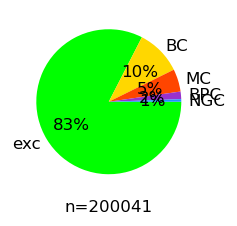

In [150]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=120)
ps = list(p_types[t] for t in cell_types)
ax.pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", counterclock=False)
ax.set_xlabel("n=" + str(total_n))
plt.show()

## not necessarily proofread spatially random

In [60]:
seg_bbox = np.array([[52770, 60616, 14850], [437618, 322718, 27858]])
resolution = np.array([4, 4, 40])
# get random locations spanning the whole depth of the cortex
n_samples = 50
sample_width = 10_000  # nm square cross section
x_vx_width = sample_width / resolution[0]
z_vx_width = sample_width / resolution[2]
rand_bboxs = []
for i in range(n_samples):
    x_min = np.random.uniform(seg_bbox[0, 0], seg_bbox[1, 0] - x_vx_width)
    z_min = np.random.uniform(seg_bbox[0, 2], seg_bbox[1, 2] - z_vx_width)
    rand_bboxs.append(np.array([[x_min, seg_bbox[0, 1], z_min], [x_min + x_vx_width, seg_bbox[1, 1], z_min + z_vx_width]]))

In [61]:
sample_cells = pd.DataFrame()
for i in range(len(rand_bboxs)):
    print(i, rand_bboxs[i])
    sample_cells = pd.concat([sample_cells, client.materialize.query_table("allen_soma_coarse_cell_class_model_v1", filter_spatial_dict={"pt_position": rand_bboxs[i]})])
    

0 [[141552.35184985  60616.          17756.11649674]
 [144052.35184985 322718.          18006.11649674]]
1 [[373328.56836557  60616.          25422.76459972]
 [375828.56836557 322718.          25672.76459972]]
2 [[262002.77798324  60616.          19298.95321264]
 [264502.77798324 322718.          19548.95321264]]
3 [[142898.91263659  60616.          20490.72343475]
 [145398.91263659 322718.          20740.72343475]]
4 [[420924.50203938  60616.          19018.37073718]
 [423424.50203938 322718.          19268.37073718]]
5 [[ 90568.70108896  60616.          16426.1915891 ]
 [ 93068.70108896 322718.          16676.1915891 ]]
6 [[431130.28377561  60616.          25418.46293139]
 [433630.28377561 322718.          25668.46293139]]
7 [[153436.9575842   60616.          20891.50218145]
 [155936.9575842  322718.          21141.50218145]]
8 [[137078.77602741  60616.          15492.20296475]
 [139578.77602741 322718.          15742.20296475]]
9 [[171047.51155843  60616.          21058.18393642]
 [

In [62]:
rand_bboxs = np.array(rand_bboxs)

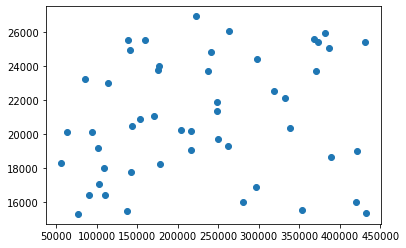

In [63]:
plt.scatter(rand_bboxs[:, 0, 0], rand_bboxs[:, 0, 2])

In [64]:
all_cells_by_root = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
all_cells_by_root.index = all_cells_by_root.pt_root_id
len(sample_cells)

436

In [65]:
synapses = client.materialize.synapse_query(pre_ids=sample_cells.pt_root_id.values)

In [66]:
len(synapses)

163913

In [93]:
client.materialize.synapse_query?

In [94]:
synapses["num_synapses"] = synapses.groupby("pre_pt_root_id").transform("count")["id"]

Text(0.5, 0, 'number of output synapses')

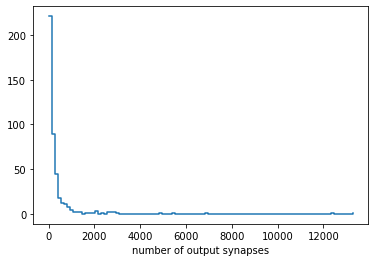

In [92]:
syn_hist, bin_edges = np.histogram(num_synapses.values, weights=1/num_synapses, bins=100)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.step(bin_edges[:-1], syn_hist, where="post")
# plt.xlim([0, 1000])
plt.xlabel("number of output synapses")

In [87]:
plt.step?

In [85]:
syn_hist

array([221.,  89.,  45.,  18.,  12.,  11.,   8.,   4.,   2.,   2.,   2.,
         0.,   1.,   1.,   1.,   3.,   0.,   1.,   0.,   2.,   2.,   2.,
         1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.])

In [96]:
valid_ids = set(all_cells_by_root.index)

In [97]:
inh_cell_types = ['BC', 'MC', 'BPC', 'NGC']  # Basket Cell, Martinotti Cell, Bipolar Cell, Nuerogliaform Cells
cell_types = ['exc'] + inh_cell_types
plot_colors = ["lime", "gold", "orangered", "darkorchid", "dodgerblue"]
type_colors = dict(zip(cell_types, plot_colors))
p_types = dict((t, 0) for t in cell_types)
total_n = 0
for i in range(len(synapses)):
    target_id = synapses.post_pt_root_id.iloc[i]
    if target_id in valid_ids and synapses.num_synapses.iloc[i] > 100:
        ctypes = all_cells_by_root.cell_type.loc[target_id]
        if type(ctypes) is str:  # make sure it's not falsely merged
            ctype = ctypes
            if ctype in inh_cell_types:
                p_types[ctype] += 1
                total_n += 1
            elif "P" in ctype:  # exc
                p_types["exc"] += 1
                total_n += 1
for t in p_types:
    p_types[t] /= total_n
print("It's roughly:", p_types)

It's roughly: {'exc': 0.7978774722624216, 'BC': 0.12161242841416503, 'MC': 0.056489418283919006, 'BPC': 0.016623993469145424, 'NGC': 0.00739668757034893}


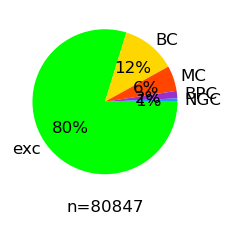

In [98]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=120)
ps = list(p_types[t] for t in cell_types)
ax.pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", counterclock=False)
ax.set_xlabel("n=" + str(total_n))
plt.show()

In [142]:
clean_output_df.num_soma

AttributeError: 'DataFrame' object has no attribute 'num_soma'